# Analyzing Financial and Economic Variables with FOMC sentiment

Alexander Ng

This section loads, imputes missing values and constructs the time series of returns or indices for regression and comparison with the sentiment indicator.

The section also demonstrates the regression between sentiment and financial or macroeconomic variables.


## Data Source

We consider 4 financial time series from the FRED database which represent interest rates, credit, inflation and equity markets.

*  **BAA10Y**, Moody's Seasoned Baa Corporate Bond yield relative to yield on 10-year Treasury Constant Maturities.  

*  **T10YIE**, the breakeven inflation rate represents the expected inflation derived from 10-Year Treasury constant maturity securities minus the 10-Year Treasury Inflation-Indexed Constant Maturity index.  It represents market expectations of average inflation over the next 10 years.

*  **WILL5000IND**, the total returns of the Wilshire 5000 Stock Index, observed daily, including reinvested dividends.  This is a broad measure of the entire US stock market.

*  **DGS10**, the yield on 10-year Treasury Constant Maturities.

Each of the above financial time series is observed at daily interval and reflected the values at market close 4pm EST.

We consider 3 macroeconomic variables which are published at monthly frequency for the US economy.  These are also sourced from the FRED database.

*  **UNRATE**, the U-3 measure of labor unemployment as published monthly by the Bureau of Labor Statistics (BLS), expressed as a percentage of the labor force of people 16 years of age or older, who are not in institutions or active military duty.  This statistic is reported for the prior month.

*  **CIVPART**, the Labor Force Participation Rate, measures the percentage of people in the labor force as a percentage of population of civilian noninstitutionalized people.

*  **PCEPILFE**, the Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index), indexed to 2012=100, is the preferred measure by the FOMC of price increases in the US.   It is a measure of the price paid for goods and services in the US.  It measures actual inflation on a backward looking basis.

We do NOT consider real GDP as an regression variable for several important reasons:

*  GDP is published quarterly, but FOMC sentiment is published every 6-8 weeks.  Thus, sentiment will change regardless of the prior GDP quarterly figure.   The mismatch in periodicity cannot easily be resolved.

*  GDP is updated 3 times as an initial release, secondary and third release.   Each release includes more complete information to estimate Gross Domestic Product.  While each revision is known to influence markets, the value of each revision is serially correlated to earlier releases.  

*  GDP release schedules don't follow a simple chronological pattern.


## Cleaning the Data

We process each FRED time series but forward filling each missing value.  Missing values occur on market holidays.
Thus, forward filling avoids backtest look-ahead bias.  We also need to coerce the data series from string to numeric which is done using `pandas.to_numeric()` call.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from IPython.display import Markdown as md

#from pandas import read_csv

fred_dir = "../fred/"

def process_fred_dateseries( csv_file, series_name ):

#  header = 0  the header row is located at row index 0
#  parse_dates - dates are at column index 0
#  index_col  -  first column is the index for the Time Series object
#
# ----------------------------------------------------
    
    df = pd.read_csv(csv_file, header = 0, parse_dates = [0], index_col = 0 )
    
    # convert blank or missing data to nan and other values from string to numeric
    df[series_name] = pd.to_numeric( df[series_name], errors = 'coerce')
    
    # Fill forward any missing data on a business holiday.
    #
    df.fillna( method = "ffill", inplace = True )
    
    df.reset_index(inplace=True)
    
    return df

#
#   Series filenames are <SERIES-KEY>.csv
#
#   Series file content:  <date>, <series-key>
# ----------------------------------------------------------------------------
def load_and_display_fred_dateseries( series_list , show_plot = False):
    
    dict_series = { }
    
    for series in series_list:
    
        sfilename = fred_dir + series + ".csv"
        
        df_series = process_fred_dateseries( sfilename, series)
        
        dict_series.update({ series : df_series } )
        
        if show_plot:
            df_series.plot( y = series )
            plt.show()
        
    return dict_series


When we run the above function on our list of FRED time series, the function returns the cleansed, imputed data series in a single object - a dictionary.

That dictionary contains a sequence of key-value pairs:

*  `key`:  the series name 

*  `value`:  pandas DataFrame whose column is the imputed data value as the series.

In addition, when we set the parameter `show_plot` = `True`, we obtain a time series plot of each series as a side-effect.


In [8]:
#
#  All the data series to be used in regression analysis.  
# -------------------------------------------------------------------------------------------
series_list = ["WILL5000IND"]

#
# Store the data series in a dictionary with:
#    key:   series key
#    value: DataFrame of dates, raw time series valuees
# 
dict_series = load_and_display_fred_dateseries(series_list, show_plot = False)

dict_series["WILL5000IND"]

,DATE,WILL5000IND
0,2006-12-01,50.41
1,2006-12-04,50.91
2,2006-12-05,51.10
3,2006-12-06,51.06
4,2006-12-07,50.85
...,...,...
4022,2022-05-03,205.44
4023,2022-05-04,211.45
4024,2022-05-05,203.68
4025,2022-05-06,202.16


## Time Dynamics

The FOMC meetings occur at 2pm EST.   We generate a series of returns for each financial variable and changes for each economic variable.

We will check if FOMC sentiment appears to influence future changes in financial markets.
For the financial variables, we consider percentage changes at 2-day and 5-day intervals.   These changes will be regressed against changes in FOMC sentiment to detect relationships.   

We will check if FOMC sentiments appears to be influenced by past changes in economic variables.
We will measure monthly changes in personal consumption, unemployment and labor participation rates and see if past changes appear to influence future changes in FOMC sentiment.

Additional data columns are appended to the dataframe of each series within the series dictionary object.   

We also visualize each resultant time series of returns along with the original time series.

In [9]:
def transform_fred_dateseries( series_dict, series_key, period, is_pct , col_name , forward_shift = 1):
    
    df_series = series_dict[ series_key]
    
    if is_pct:
        df_series[ col_name ] = df_series[series_key].pct_change( periods = period )
        if period < 0:
            df_series[ col_name ] = -1 * df_series[ col_name]
        df_series[ col_name ] = df_series[col_name ].shift( periods = forward_shift)  # Forward shift
    else:
        df_series[ col_name ] = df_series[series_key].diff( periods = period )
        
        if period < 0:
            df_series[ col_name ] = -1 * df_series[ col_name]
        df_series[ col_name ] = df_series[col_name ].shift( periods = forward_shift)  # Forward shift


transform_fred_dateseries( dict_series, "WILL5000IND", -2,  is_pct = True, col_name = "fp2")
transform_fred_dateseries( dict_series, "WILL5000IND", -5,  is_pct = True, col_name = "fp5")

# 5 back, and 7 forward, (so 2 ahead)
transform_fred_dateseries( dict_series, "WILL5000IND", -7,  is_pct = True, col_name = "fp7s5", forward_shift = 5)

# for loop for Wilshire data
# forward_shift 5 to 0
# period -10 to -5
for fs in range(5,-1,-1):
    for per in range(-fs-5,-fs,1):
        col_name_cat = 'fp'+ str(-1*per) + 's' + str(fs)
        transform_fred_dateseries( dict_series, "WILL5000IND", per,  is_pct = True, col_name = col_name_cat, forward_shift = fs)


## Specifying the Regressions

We implement the dataframes containing the variables to be regressed below.

* The sentiment indicator is put into a dataframe called `df_sentiment`

* The market variables to be regressed are aligned by date.

We use the pandas `merge_asof` to do approximate date matching correctly.
Its logic aligns each FOMC date to the closest prior date of each other published financial or economic time series. 

Each univariate regression is displayed below for analysis using a scatter plot.

In [10]:
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore

# Get the true sentiment scores produced from running the Loughran-McDonald financial library on the FOMC statements for polarity
derived_data_dir = "../derived"
fomc_statements_file = derived_data_dir + "/" + "FOMC_statements_with_sentiment_score.csv"
df_fomc_statements_raw = pd.read_csv( fomc_statements_file , parse_dates=[1], header = 0)

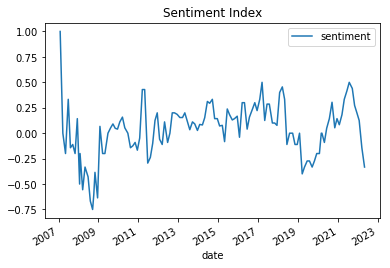

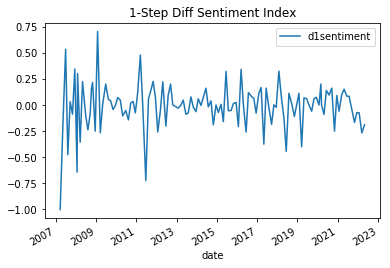

In [11]:
# Extract the column from the input that represents the Loughran-McDonald sentiment scores 
df_sentiment = pd.DataFrame( df_fomc_statements_raw["date"] )
df_sentiment["sentiment"] = df_fomc_statements_raw["text_token_score_lm"]

# Plot the sentiment scores as a time series
df_sentiment.plot(x = "date", y = "sentiment")
plt.title("Sentiment Index")
plt.show()

# Calculate the difference from previous row
df_sentiment[ "d1sentiment" ] = df_sentiment["sentiment"].diff( periods = 1 )
df_sentiment

# Plot the sentiment score difference as a time series
df_sentiment.plot(x = "date", y = "d1sentiment")
plt.title("1-Step Diff Sentiment Index")
plt.show()

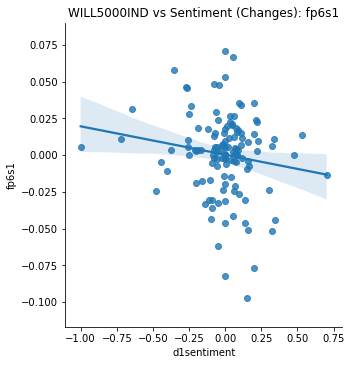

                            OLS Regression Results                            
Dep. Variable:                  fp6s1   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.861
Date:                Fri, 13 May 2022   Prob (F-statistic):             0.0933
Time:                        13:52:38   Log-Likelihood:                 269.88
No. Observations:                 124   AIC:                            -535.8
Df Residuals:                     122   BIC:                            -530.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0003      0.002      0.120      

In [12]:
WILL5000IND = dict_series["WILL5000IND"]

df_sent_WILL5000IND = pd.merge_asof(df_sentiment, WILL5000IND, left_on = "date", right_on = "DATE")

for fs in range(5,-1,-1):
    #print(fs)
    for per in range(-fs-5,-fs,1):
        y_col = 'fp'+ str(-1*per) + 's' + str(fs)
        #sns.lmplot( x= 'd1sentiment', y = y_col, data = df_sent_WILL5000IND, fit_reg=True, legend=True)
        #plt.title("WILL5000IND vs Sentiment (Changes): " + y_col)
        #plt.show()

        # Generate linear regression model
        mod_WILL5000IND = sm.OLS(df_sent_WILL5000IND[y_col], sm.add_constant(df_sent_WILL5000IND['d1sentiment']), missing='drop')
        mod_fit_WILL5000IND = mod_WILL5000IND.fit()
        #print(mod_fit_WILL5000IND.summary())
        
        pval = mod_fit_WILL5000IND.pvalues['d1sentiment']
        # Only display if p-value less than 10% (0.1)
        if pval < 0.1:
            sns.lmplot( x= 'd1sentiment', y = y_col, data = df_sent_WILL5000IND, fit_reg=True, legend=True)
            plt.title("WILL5000IND vs Sentiment (Changes): " + y_col)
            plt.show()
            print(mod_fit_WILL5000IND.summary())        